In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

No joblib
no cmocean


In [2]:
# ==============================================================================
# Running this file loads tracers from old FESOM-REcoM2 output file (oce.mean.nc)
# and saves each tracer in an individual file
# 
#  Input:
#  - mesh_id: Name of mesh, will be added to the netcdf name
#  - meshpath: Speciefies where the target mesh is stored
#  - save_netcdf: If true, netcdf will be created
#  - delete_old_netcdf: If a netcdf file with the same name exists, a new cannot 
#    be made. If set to true, an old netcdf with the same name will be deleted
#
#  Output:
#  - netcdf file for each tracer in the old file
#  
#  During running, keep an eye on the output in the terminal, to see if it 
#  makes sense. 
#
# ==============================================================================

In [48]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'NUTRICLINE'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [27]:
mesh


FESOM mesh:
path                  = /home/hbkoziel/pyfesom/data/mesh/meshArc4.5
alpha, beta, gamma    = 50, 15, -90
number of 2d nodes    = 753179
number of 2d elements = 1480268
number of 3d nodes    = 16950142

        

In [28]:
# ==============================================================================
# Settings for netcdf file

save_netcdf       = True                                            # Saves the interpolated field in netcdf file
delete_old_netcdf = True                                            # If a netcdf file with the same name exists it will be deleted
input_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'       # Where the netcdf is saved
output_directory  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'

In [ ]:
for ind in range(0,len(years)):
    netcdf_name       = tracername+'.'+str(years[ind])+'.monthly.nc'
    print years[ind]
    # ==============================================================================
    # Loading data

    ncfile1	= input_directory+'tr01.'+str(years[ind])+'.monthly.nc'
    f1	= Dataset(ncfile1,'r')
    din	= f1.variables['tr01'][:,:]
    f1.close()
    
    NUT = np.zeros((12,len(mesh.x2)))
    for month in range(0,12):
        print(month)
        for i in range(0,len(mesh.x2)):
            max_depth = mesh.topo[i]
            if ((mesh.y2[i] >= 68) & (max_depth > 230)):
                ind_depth = np.array(mesh.n32[i,:]) # depth max 580m
                ind_depth = np.reshape(ind_depth, ind_depth.size)
                ind_depth = ind_depth[ind_depth > -999]
                ind_deep = np.where((mesh.z3[ind_depth]>=230) & (mesh.z3[ind_depth]<=340))
#                 z = pressure[ind_depth]

#                 tt = t[month,ind_depth]
#                 tt = np.reshape(tt, tt.size)
#                 ss = s[month,ind_depth]
#                 ss = np.reshape(ss, ss.size)
#                 ro = gsw.rho(ss,tt,z)
                hl_ind = np.abs(din[month,ind_depth]-din[month,ind_depth[0]]-0.20*(np.nanmean(din[month,ind_depth[ind_deep]])-din[month,ind_depth[0]])).argmin(axis=0)
                NUT[month,i] = mesh.z3[ind_depth[hl_ind]]
            else:
                NUT[month,i] = np.nan
        
            
    tracershape = np.shape(NUT)
    
    # ==============================================================================
    # Testing if a netcdf file with the same name exists, if yes, it must be removed
    # to save a new one.

    if os.path.isfile(output_directory+netcdf_name) and delete_old_netcdf:
      os.remove(output_directory+netcdf_name)
      print "The netcdf file "+netcdf_name+" has been deleted to make room for your file of the same name."
    elif os.path.isfile(netcdf_name):
      statement = "The netcdf file "+netcdf_name+" already exists! It must be removed for a new one to be created. This can be done by changing your settings."
      sys.exit(statement)

    if not os.path.isdir(output_directory):
      os.makedirs(output_directory)
      print 'Directory '+output_directory+' has been created'

    # ==============================================================================
    # Creating netcdf file
    if save_netcdf:  
      import time
      w_nc_fid = Dataset(output_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
      w_nc_fid.description = 'Nitracline'
      w_nc_fid.history     = 'Created ' + time.ctime(time.time())

      nod2d    = w_nc_fid.createDimension('nod2d', mesh.n2d)               # Create dimension: number of 3d nodes
      time	   = w_nc_fid.createDimension('time', tracershape[0])
                          
      w_nc_var = w_nc_fid.createVariable('NUT', 'f4',('time','nod2d'))           # 'DIN' is name of saved variable                                                                    # 'f8' sets presicion to 64-bit floating point
      w_nc_var.setncatts({'long_name': u'NUT',\
                          'units': u'm'})
      w_nc_fid.variables['NUT'][:] = NUT  
    
      w_nc_fid.close()                                                     # close the new file                

      cwd = os.getcwd()
      print "New netcdf file (",netcdf_name,") has been created."
      print "Location: "+output_directory
    else:
      print 'You have specified not to save your field in netcdf file'

1985
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file NUTRICLINE.1985.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( NUTRICLINE.1985.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
1986
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file NUTRICLINE.1986.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( NUTRICLINE.1986.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
1987
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file NUTRICLINE.1987.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( NUTRICLINE.1987.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Arc12/netcdf_monthly/
1988
0
1
2
3
4
5
6
7
8
9
10
11
The netcdf file NUTRICLINE.1988.monthly.nc has been deleted to make room for your file of the same name.
New netcdf file ( NUTRICLINE.1988.monthly.nc ) has been created.
Location: /scratch/usr/hbkoziel/Ar

/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


For depth 0 model level -0.0 will be used


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal


For depth 0 model level -0.0 will be used


Text(0.5,1,'March')

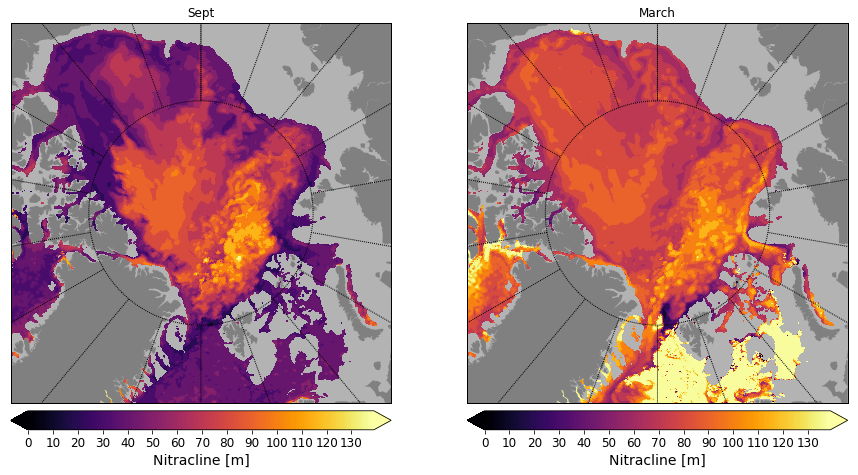

In [47]:
fig = plt.figure(figsize=(15, 10), facecolor='w', edgecolor='k')

ax1      = fig.add_subplot(121)
#hadv[ind_all] = np.nan
data = NUT[8,:]
contours = np.arange(0, 140, 1)
eps=(contours.max()-contours.min())/100.
data[data<=contours.min()]=contours.min()+eps
data[data>=contours.max()]=contours.max()-eps
data, elem_no_nan = pf.get_data(data,mesh,0)
m = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cm.inferno, extend='both')
label = 'Nitracline [m]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(0, 140, 10))
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('Sept')

ax2      = fig.add_subplot(122)
#hadv[ind_all] = np.nan
data = NUT[2,:]
contours = np.arange(0, 140, 1)
eps=(contours.max()-contours.min())/100.
data[data<=contours.min()]=contours.min()+eps
data[data>=contours.max()]=contours.max()-eps
data, elem_no_nan = pf.get_data(data,mesh,0)
m = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cm.inferno, extend='both')
label = 'Nitracline [m]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks=np.arange(0, 140, 10))
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('March')

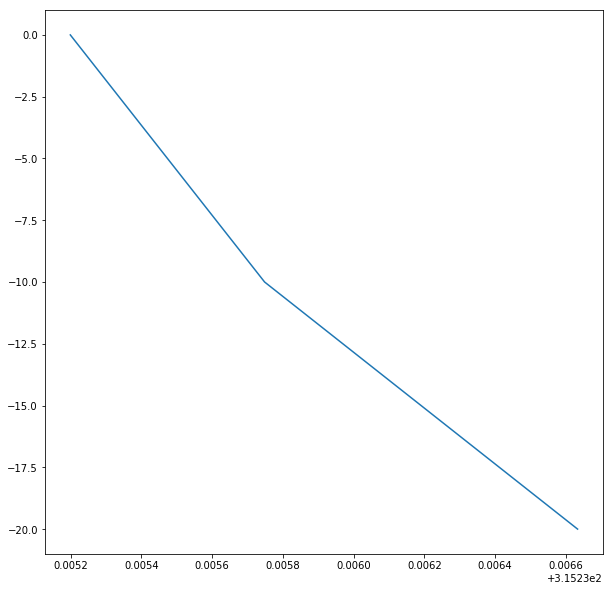

In [19]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(din[month,ind_depth],-mesh.z3[ind_depth])

In [20]:
din[month,ind_depth]

masked_array(data=[315.2352 , 315.23575, 315.23663],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [31]:
np.shape(din)

(12, 16950142)

In [36]:
ind_deep = np.where((mesh.z3[ind_depth]>=230) & (mesh.z3[ind_depth]<=340))
ind_deep

(array([15, 16]),)

In [34]:
mesh.zlevs

array([  -0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  115.,  135.,  160.,  190.,  230.,  280.,  340.,
        410.,  490.,  580.,  680.,  790.,  910., 1040., 1180., 1330.,
       1500., 1700., 1920., 2150., 2400., 2650., 2900., 3150., 3400.,
       3650., 3900., 4150., 4400., 4650., 4900., 5150., 5400., 5650.,
       5900.])

In [37]:
ind_depth[ind_deep]

array([ 9509925, 10013968])

In [41]:
np.nanmean(din[month,ind_depth[ind_deep]])

12.458139

In [40]:
din[month,ind_depth[ind_deep]]

masked_array(data=[12.36419 , 12.552088],
             mask=False,
       fill_value=1e+20,
            dtype=float32)